# Анализ факторов, влияющих на скорость принятия законопроектов: построение модели Кокса

Этот файл содержит полный процесс анализа данных о законопроектах, включающий предобработку данных, построение регрессионной модели Кокса и визуализацию результатов.

In [2]:
pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from tabulate import tabulate
import warnings
import re
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction import FeatureHasher
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter
from lifelines.statistics import proportional_hazard_test
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

### Предобработка данных

Откроем файл с данными, которые получились после парсинга:

In [138]:
data = pd.read_csv('all_bills_6th_and_7th_convocation.csv')
data.head(5)

,Субъект права законодательной инициативы,Форма законопроекта,Ответственный комитет,Отрасль законодательства,Тематический блок законопроектов,Профильный комитет,Пакет документов при внесении,Номер,Ссылка,Дата внесения,...,Заключение Правительства РФ на законопроект,Предмет ведения,Комитеты-соисполнители,Вопрос ведения,Новая редакция законопроекта,Наличие актуального Заключения Правового Управления,Планируемый месяц рассмотрения согласно Примерной программе,Принадлежность к примерной программе,Срок представления поправок,Планируемая дата рассмотрения законопроекта согласно календарю
0,Депутат Государственной Думы Д.В.Ушаков,Федеральный закон,"Комитет Государственной Думы по труду, социаль...",060.000.000 Труд и занятость населения,Социальная политика,"Комитет Государственной Думы по труду, социаль...",NaN,№1187320-6,https://sozd.duma.gov.ru/bill/1187320-6,04.10.2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Депутат Государственной Думы Д.В.Ушаков,Федеральный закон,"Комитет Государственной Думы по труду, социаль...",060.000.000 Труд и занятость населения,Социальная политика,"Комитет Государственной Думы по труду, социаль...",NaN,№1187319-6,https://sozd.duma.gov.ru/bill/1187319-6,04.10.2016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Депутаты Государственной Думы М.В.Емельянов, Д...",Федеральный закон,Комитет Государственной Думы по бюджету и налогам,NaN,"Бюджетное, налоговое, финансовое законодательство",Комитет Государственной Думы по бюджету и налогам,NaN,№1187318-6,https://sozd.duma.gov.ru/bill/1187318-6,04.10.2016,...,Не требуется,Совместное ведение,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Правительство Российской Федерации,Федеральный закон,Комитет Государственной Думы по делам Содружес...,200.000.000 Международные отношения. Междунаро...,Ратификация международных договоров Российской...,Комитет Государственной Думы по делам Содружес...,NaN,№1187317-6,https://sozd.duma.gov.ru/bill/1187317-6,04.10.2016,...,Не требуется,Ведение РФ,Комитет Государственной Думы по международным ...,Ведение Конституционного Суда РФ,NaN,NaN,NaN,NaN,NaN,NaN
4,Депутат Государственной Думы В.Н.Тетекин,Федеральный закон,Комитет Государственной Думы по бюджету и налогам,NaN,NaN,Комитет Государственной Думы по бюджету и налогам,NaN,№1187303-6,https://sozd.duma.gov.ru/bill/1187303-6,04.10.2016,...,NaN,Совместное ведение,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
data.columns

Index(['Субъект права законодательной инициативы', 'Форма законопроекта',
       'Ответственный комитет', 'Отрасль законодательства',
       'Тематический блок законопроектов', 'Профильный комитет',
       'Пакет документов при внесении', 'Номер', 'Ссылка', 'Дата внесения',
       'Дата принятия/не принятия', 'Статус', 'Созыв',
       'Заключение Правительства РФ на законопроект', 'Предмет ведения',
       'Комитеты-соисполнители', 'Вопрос ведения',
       'Новая редакция законопроекта',
       'Наличие актуального Заключения Правового Управления',
       'Планируемый месяц рассмотрения согласно Примерной программе',
       'Принадлежность к примерной программе', 'Срок представления поправок',
       'Планируемая дата рассмотрения законопроекта согласно календарю'],
      dtype='object')

In [140]:
data.shape

(12867, 23)

Полученные данные содержат столбцы, которые не будут использоваться в модели. Удалим их, оставив только те переменные, которые необходимы для дальнейшего анализа:

In [141]:
columns_to_drop = [
    'Заключение Правительства РФ на законопроект',
    'Предмет ведения',
    'Вопрос ведения',
    'Новая редакция законопроекта',
    'Наличие актуального Заключения Правового Управления',
    'Планируемый месяц рассмотрения согласно Примерной программе',
    'Принадлежность к примерной программе',
    'Срок представления поправок',
    'Планируемая дата рассмотрения законопроекта согласно календарю'
]

data = data.drop(columns=columns_to_drop)

In [142]:
columns_rename = {
    'Субъект права законодательной инициативы': 'Initiator',
    'Форма законопроекта': 'BillForm',
    'Ответственный комитет': 'ResponsibleCommittee',
    'Отрасль законодательства': 'LegislationSector',
    'Тематический блок законопроектов': 'ThematicBlock',
    'Профильный комитет': 'ProfileCommittee',
    'Пакет документов при внесении': 'SubmissionDocuments',
    'Номер': 'Number',
    'Ссылка': 'Link',
    'Дата внесения': 'SubmissionDate',
    'Дата принятия/не принятия': 'AdoptionDate',
    'Статус': 'Status',
    'Созыв': 'Convocation',
    'Комитеты-соисполнители': 'CoCommittees'
}

data = data.rename(columns=columns_rename)

In [143]:
billform_mapping = {
    'Федеральный закон': 'federal_law',
    'Федеральный конституционный закон': 'constitutional_federal_law',
    'Закон Российской Федерации о поправке к Конституции Российской Федерации': 'constitutional_amendment_law'
}


data['BillForm'] = data['BillForm'].map(billform_mapping)

In [144]:
data['ThematicBlock_cleaned'] = data['ThematicBlock']

data['ThematicBlock_cleaned'] = data['ThematicBlock_cleaned'].str.replace(
    'Бюджетное, налоговое, финансовое законодательство',
    'Бюджетное налоговое финансовое законодательство'
)

data['ThematicBlock_cleaned'] = data['ThematicBlock_cleaned'].str.replace(
    'Государственное строительство и конституционные права граждан, Оборона и безопасность',
    'Государственное строительство и конституционные права граждан; Оборона и безопасность'
)

data['Thematic_List'] = data['ThematicBlock_cleaned'].apply(
    lambda x: [i.strip() for i in x.split(';')] if isinstance(x, str) else []
)

thematic_mapping = {
    'Социальная политика': 'social_policy',
    'Бюджетное налоговое финансовое законодательство': 'budget_and_tax_policy',
    'Ратификация международных договоров Российской Федерации': 'international_treaties',
    'Экономическая политика': 'economic_policy',
    'Государственное строительство и конституционные права граждан': 'state_structure_and_constitutional_rights',
    'Оборона и безопасность': 'defense_and_security'
}

data['Thematic_List'] = data['Thematic_List'].apply(
    lambda lst: [thematic_mapping[i] for i in lst if i in thematic_mapping]
)

mlb = MultiLabelBinarizer()
theme_encoded = pd.DataFrame(
    mlb.fit_transform(data['Thematic_List']),
    columns=mlb.classes_
)

theme_encoded.drop(columns=['state_structure_and_constitutional_rights'], inplace=True)
data = pd.concat([data.reset_index(drop=True), theme_encoded.reset_index(drop=True)], axis=1)

Преобразуем статус законопроекта в числовой формат: принятие обозначим как 1, непринятие — как 0, чтобы использовать переменную в качестве целевой в модели.

In [147]:
data['Status_binary'] = data['Status'].map({'принят': 1, 'не принят': 0})

Вычислим продолжительность рассмотрения законопроекта в днях — от даты внесения до даты принятия.

In [148]:
data['SubmissionDate'] = pd.to_datetime(data['SubmissionDate'], errors='coerce', dayfirst=True)
data['AdoptionDate'] = pd.to_datetime(data['AdoptionDate'], errors='coerce', dayfirst=True)
data['Duration'] = (data['AdoptionDate'] - data['SubmissionDate']).dt.days

In [149]:
data_old = data.copy()

Сделаем новый столбец с именем актора и очистим иницатора до института, который предлагал законопроект на рассмотрение.

In [150]:
def extract_actor(initiator):
    matches = re.findall(r'[А-ЯЁ]\.[А-ЯЁ]\.[А-ЯЁ][а-яё]+', initiator)
    if matches:
        return ', '.join(matches)
    return None
def remove_actor(initiator):
    return re.sub(r'[А-ЯЁ]\.[А-ЯЁ]\.[А-ЯЁ][а-яё]+', '', initiator).strip()

data['Actors'] = data['Initiator'].apply(extract_actor)
data['Initiator'] = data['Initiator'].apply(remove_actor)

In [151]:
def extract_institution_names(text):
    if not isinstance(text, str):
        return None

    text = text.lower()
    text = re.sub(r'[^\w\s\-\(\)]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    matches = re.findall(
        r'((?:[а-яё]+\s+){0,4}(?:дума|собрание|совет|хурал|парламент|правительство)[а-яё\s\-\(\)]{0,30})',
        text
    )

    cleaned = set()
    for m in matches:
        phrase = m.strip()
        if len(phrase.split()) >= 2 and 'депутат' not in phrase:
            cleaned.add(phrase)

    if re.search(r'депутат(ы)?\s+государственной\s+думы', text):
        cleaned.add('депутаты государственной думы')
    if re.search(r'члены?\s+совета\s+федерации', text):
        cleaned.add('члены совета федерации')
    if 'правительство российской федерации' in text:
        cleaned.add('правительство российской федерации')
    if re.search(r'президент\s+российской\s+федерации', text):
        cleaned.add('президент российской федерации')
    if re.search(r'(верховный|высший арбитражный|арбитражный)\s+суд', text):
        cleaned.add('суд российской федерации')
    if re.search(r'сенатор(ы)?\s+российской\s+федерации', text):
        cleaned.add('члены совета федерации')
    if re.search(r'областн\w*\s+(совет|собрание)\s+депутатов', text):
        cleaned.add('региональный парламент')
    if re.search(r'совет\s+народных\s+депутатов', text):
        cleaned.add('региональный парламент')
    if re.search(r'собрание\s+депутатов\s+[а-яё\s\-]+', text):
        cleaned.add('региональный парламент')


    return '; '.join(sorted(cleaned)) if cleaned else None
data['Initiator'] = data['Initiator'].apply(extract_institution_names)

Стандартизируем инициаторов: объединяем схожие формулировки (например, "депутаты Госдумы" и "депутат Госдумы") и кодируем их в числовой формат для дальнейшего анализа.

In [152]:
actor_normalization = {
    'депутаты государственной думы': 'state_duma',
    'депутат государственной думы': 'state_duma',
    'члены совета федерации': 'federation_council',
    'член совета федерации': 'federation_council',
    'правительство российской федерации': 'government',
    'президент российской федерации': 'president',
    'суд российской федерации': 'court',
    'региональный парламент': 'regional_parliament',
    'законодательное собрание': 'regional_parliament',
    'областная дума': 'regional_parliament',
    'губернская дума': 'regional_parliament',
    'государственное собрание': 'regional_parliament',
    'народное собрание': 'regional_parliament',
    'государственный совет': 'regional_parliament',
    'верховный хурал': 'regional_parliament',
    'дума': 'regional_parliament',
    'парламент': 'regional_parliament',
}

def standardize_actors(text):
    if not isinstance(text, str):
        return None
    text = text.lower()
    
    text = re.sub(r'[,;]+', ';', text)
    text = re.sub(r'\s{2,}', ' ', text)
    
    parts = [p.strip() for p in text.split(';') if p.strip()]
    
    normalized = set()
    for part in parts:
        for key, replacement in actor_normalization.items():
            if key in part:
                normalized.add(replacement)
                break  
    return ';'.join(sorted(normalized)) if normalized else None
data['Initiator'] = data['Initiator'].apply(standardize_actors)

In [153]:
data['Initiator_List'] = data['Initiator'].apply(lambda x: x.split(';') if isinstance(x, str) else [])

mlb = MultiLabelBinarizer()
binary_encoded = mlb.fit_transform(data['Initiator_List'])

binary_df = pd.DataFrame(binary_encoded, columns=[f"actor_{c}" for c in mlb.classes_])
binary_df = binary_df.drop(columns=["actor_state_duma"])
data = pd.concat([data.reset_index(drop=True), binary_df.reset_index(drop=True)], axis=1)

Теперь посчитаем, сколько инициаторов участвовало в каждом законопроекте.

In [154]:
data['Actors_Count'] = data['Actors'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

Закодируем категориальные переменные, BillForm и ThematicBlock, через one-hot (так как категорий немного), а ResponsibleCommittee — через hash encoding, чтобы сократить размерность (исходных комитетов 56).

In [155]:
billform_ohe = pd.get_dummies(data['BillForm'], prefix='billform', drop_first=True).astype(int)

data = pd.concat([data, billform_ohe], axis=1)

In [156]:
committee_series = data['ResponsibleCommittee'].fillna('missing').astype(str)

committee_values = committee_series.tolist()

hasher = FeatureHasher(n_features=8, input_type='string', alternate_sign=False)  

committee_hashed = hasher.transform([[x] for x in committee_values])  

committee_hashed_df = pd.DataFrame(
    committee_hashed.toarray(),
    columns=[f'committee_hash_{i}' for i in range(8)]
)

data = pd.concat([data.reset_index(drop=True), committee_hashed_df.reset_index(drop=True)], axis=1)

Преобразуем переменную, обозначающую законодательный созыв, в бинарную переменную.

In [157]:
data['convocation_binary'] = data['Convocation'].map({6: 0, 7: 1})

Перейдем к определению аффиляции депутатов с правительством. В датафрейме с биографией закодируем аффиляцию как наличие опыта государственной службы, а также приведём ФИО к сокращенному формату для удобства дальнейшего сопоставления с основным датафреймом.

In [158]:
data_aff_gov = pd.read_csv('Deputies 6.csv', sep=';') 
data_aff_gov.head(3)

,Id,Surname,Name,Patronymic,CurrentPosition,IsActive,Sex,BirthDate,DeathDate,AcademicTitle_1,...,Region_22,Region_Session_22,Senator_Council_Branch_1,Senator_Council_Region_1,Senator_Council_Start_1,Senator_Council_End_1,Senator_Council_Branch_2,Senator_Council_Region_2,Senator_Council_Start_2,Senator_Council_End_2
0,99100052,Булавинов,Вадим,Евгеньевич,Депутат,не активен,Male,20.03.1963,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99100099,Говорухин,Станислав,Сергеевич,Депутат,не активен,Male,29.03.1936,14.06.2018,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,99100110,Грешневиков,Анатолий,Николаевич,Депутат,активен,Male,29.08.1956,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
def format_name(row):
    if pd.isnull(row['Surname']) or pd.isnull(row['Name']):
        return None
    initials = row['Name'][0] + '.'
    if pd.notnull(row['Patronymic']) and isinstance(row['Patronymic'], str) and len(row['Patronymic']) > 0:
        initials += row['Patronymic'][0] + '.'
    return f"{initials}{row['Surname']}"

data_aff_gov['Short_Name'] = data_aff_gov.apply(format_name, axis=1)

In [160]:
affiliation_pattern = r'государственная служба|государственная корпорация|партийный работник|силовые структуры'

data_aff_gov['Is_Affiliated'] = (
    data_aff_gov['WorkplaceGroup']
    .astype(str)
    .str.contains(affiliation_pattern, case=False, na=False)
    .astype(int)
)

Добавим аффиляцию в исходный датафрейм.

In [161]:
affiliated_dict = data_aff_gov.set_index('Short_Name')['Is_Affiliated'].to_dict()

def check_affiliation(actor_string):
    if not isinstance(actor_string, str):
        return 0
    actor_list = [a.strip() for a in actor_string.split(',')]
    return int(any(affiliated_dict.get(actor, 0) == 1 for actor in actor_list))
    
data['Affiliation'] = data['Actors'].apply(check_affiliation)

Добавим переменную, отражающую количество дней, оставшихся до окончания созыва на момент подачи законопроекта.

In [162]:
convocation_end_dates = {
    6: pd.to_datetime('2016-10-04'),
    7: pd.to_datetime('2021-09-30')
}


data['convocation_end_date'] = data['Convocation'].map(convocation_end_dates)
data['DaysToEnd'] = (data['convocation_end_date'] - data['SubmissionDate']).dt.days

Определим уровень политической неопределённости на момент подачи законопроекта, используя индекс Economic Policy Uncertainty. Для каждой даты подачи законопроекта сопоставлено ближайшее по времени значение индекса, рассчитанного на основе анализа новостных публикаций. 

In [163]:
df_polunc = pd.read_excel('Russia_Policy_Uncertainty_Data-2.xlsx')

In [164]:
df_polunc = df_polunc.dropna(subset=['Year', 'Month'])
df_polunc['Month'] = df_polunc['Month'].astype(int)
df_polunc['date'] = pd.to_datetime(df_polunc['Year'].astype(str) + '-' + df_polunc['Month'].astype(str) + '-01')
df_polunc.rename(columns={'News-Based Policy Uncertainty Index': 'uncertainty_index'}, inplace=True)
df_polunc = df_polunc[['date', 'uncertainty_index']]

def find_closest_index(submission_date):
    diffs = abs(df_polunc['date'] - submission_date)
    idx_min = diffs.idxmin()
    return df_polunc.loc[idx_min, 'uncertainty_index']

data['uncertainty_index'] = data['SubmissionDate'].apply(find_closest_index)

Удалим все не нужные столбцы.

In [165]:
columns_to_drop = [
    'SubmissionDate', 'AdoptionDate',
    'BillForm', 'ThematicBlock', 'Status',
    'ResponsibleCommittee', 'LegislationSector',
    'ProfileCommittee', 'Number', 'Link',
    'Convocation', 'CoCommittees', 'SubmissionDocuments',
    'Actors', 'Initiator_List', 'Initiator', 'convocation_end_date',
    'ThematicBlock_cleaned'
]

data = data.drop(columns=columns_to_drop)

In [168]:
data.isna().sum()

budget_and_tax_policy                  0
defense_and_security                   0
economic_policy                        0
international_treaties                 0
social_policy                          0
Status_binary                          0
Duration                               0
actor_court                            0
actor_federation_council               0
actor_government                       0
actor_president                        0
actor_regional_parliament              0
Actors_Count                           0
billform_constitutional_federal_law    0
billform_federal_law                   0
committee_hash_0                       0
committee_hash_1                       0
committee_hash_2                       0
committee_hash_3                       0
committee_hash_4                       0
committee_hash_5                       0
committee_hash_6                       0
committee_hash_7                       0
convocation_binary                     0
Affiliation     

In [169]:
data.dtypes

budget_and_tax_policy                    int64
defense_and_security                     int64
economic_policy                          int64
international_treaties                   int64
social_policy                            int64
Status_binary                            int64
Duration                                 int64
actor_court                              int64
actor_federation_council                 int64
actor_government                         int64
actor_president                          int64
actor_regional_parliament                int64
Actors_Count                             int64
billform_constitutional_federal_law      int64
billform_federal_law                     int64
committee_hash_0                       float64
committee_hash_1                       float64
committee_hash_2                       float64
committee_hash_3                       float64
committee_hash_4                       float64
committee_hash_5                       float64
committee_has

### EDA 

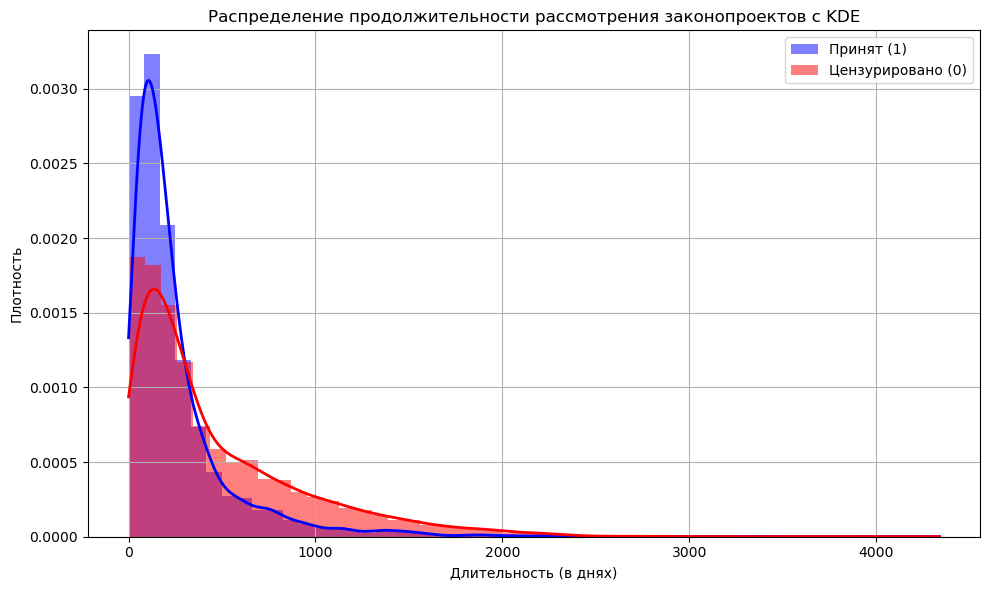

In [27]:
accepted = data[data['Status_binary'] == 1]['Duration'].dropna()
censored = data[data['Status_binary'] == 0]['Duration'].dropna()

plt.figure(figsize=(10, 6))
plt.hist(accepted, bins=50, alpha=0.5, label='Принят (1)', color='blue', density=True)
plt.hist(censored, bins=50, alpha=0.5, label='Цензурировано (0)', color='red', density=True)

x_vals = np.linspace(data['Duration'].min(), data['Duration'].max(), 1000)

kde_accepted = gaussian_kde(accepted)
kde_censored = gaussian_kde(censored)

plt.plot(x_vals, kde_accepted(x_vals), color='blue', linewidth=2)
plt.plot(x_vals, kde_censored(x_vals), color='red', linewidth=2)

plt.title('Распределение продолжительности рассмотрения законопроектов с KDE')
plt.xlabel('Длительность (в днях)')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

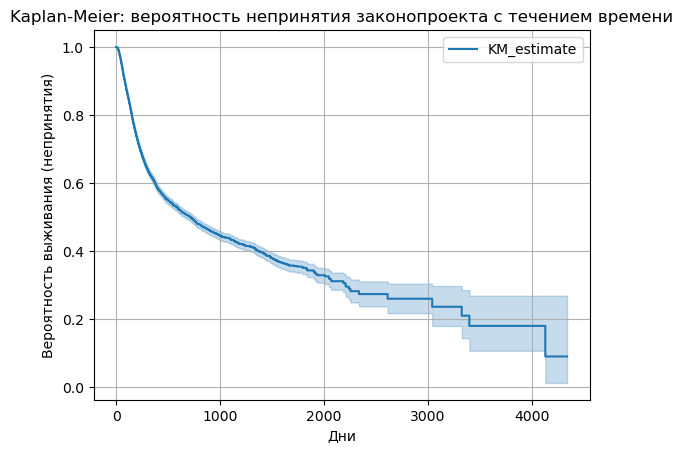

In [373]:
kmf = KaplanMeierFitter()
kmf.fit(durations=data['Duration'], event_observed=data['Status_binary'])
kmf.plot_survival_function()
plt.title('Kaplan-Meier: вероятность непринятия законопроекта с течением времени')
plt.xlabel('Дни')
plt.ylabel('Вероятность выживания')
plt.grid(True)
plt.show()

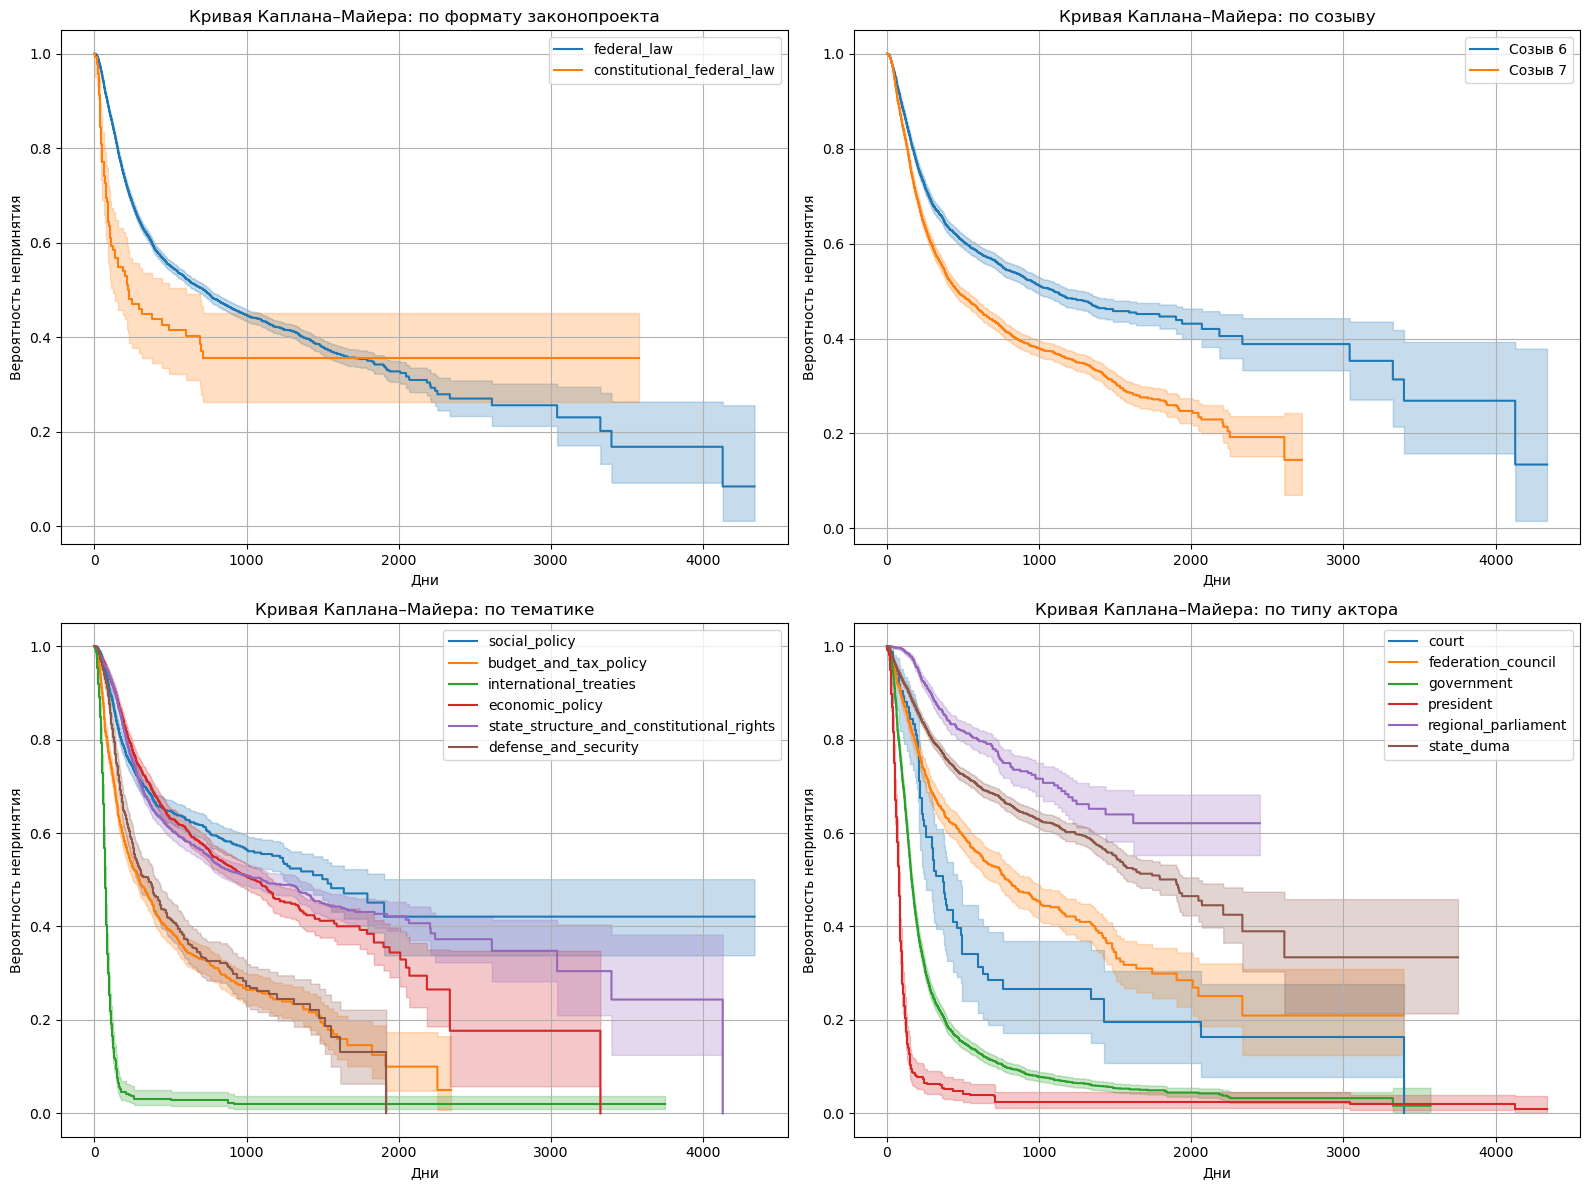

In [74]:
actor_cols = [col for col in data.columns if col.startswith('actor_')]

kmf = KaplanMeierFitter()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
for category in data_old['BillForm'].dropna().unique():
    mask = data_old['BillForm'] == category
    if mask.sum() > 50:
        kmf.fit(data_old[mask]['Duration'], event_observed=data_old[mask]['Status_binary'], label=category)
        kmf.plot_survival_function(ax=ax)
ax.set_title('Кривая Каплана–Майера: по формату законопроекта')
ax.set_xlabel('Дни')
ax.set_ylabel('Вероятность непринятия')
ax.grid(True)

ax = axes[0, 1]
for conv in sorted(data['convocation_binary'].unique()):
    mask = data['convocation_binary'] == conv
    label = f"Созыв {6 + conv}"
    if mask.sum() > 50:
        kmf.fit(data[mask]['Duration'], event_observed=data[mask]['Status_binary'], label=label)
        kmf.plot_survival_function(ax=ax)
ax.set_title('Кривая Каплана–Майера: по созыву')
ax.set_xlabel('Дни')
ax.set_ylabel('Вероятность непринятия')
ax.grid(True)


ax = axes[1, 0]
for category in data_old['ThematicBlock'].dropna().unique():
    mask = data_old['ThematicBlock'] == category
    if mask.sum() > 50:
        kmf.fit(data_old[mask]['Duration'], event_observed=data_old[mask]['Status_binary'], label=category)
        kmf.plot_survival_function(ax=ax)
ax.set_title('Кривая Каплана–Майера: по тематике')
ax.set_xlabel('Дни')
ax.set_ylabel('Вероятность непринятия')
ax.grid(True)

ax = axes[1, 1]
actor_cols = [col for col in data.columns if col.startswith('actor_')]
for col in actor_cols:
    mask = data[col] == 1
    if mask.sum() > 50:
        kmf.fit(data[mask]['Duration'], event_observed=data[mask]['Status_binary'], label=col.replace('actor_', ''))
        kmf.plot_survival_function(ax=ax)
ax.set_title('Кривая Каплана–Майера: по типу актора')
ax.set_xlabel('Дни')
ax.set_ylabel('Вероятность непринятия')
ax.grid(True)

plt.tight_layout()
plt.show()

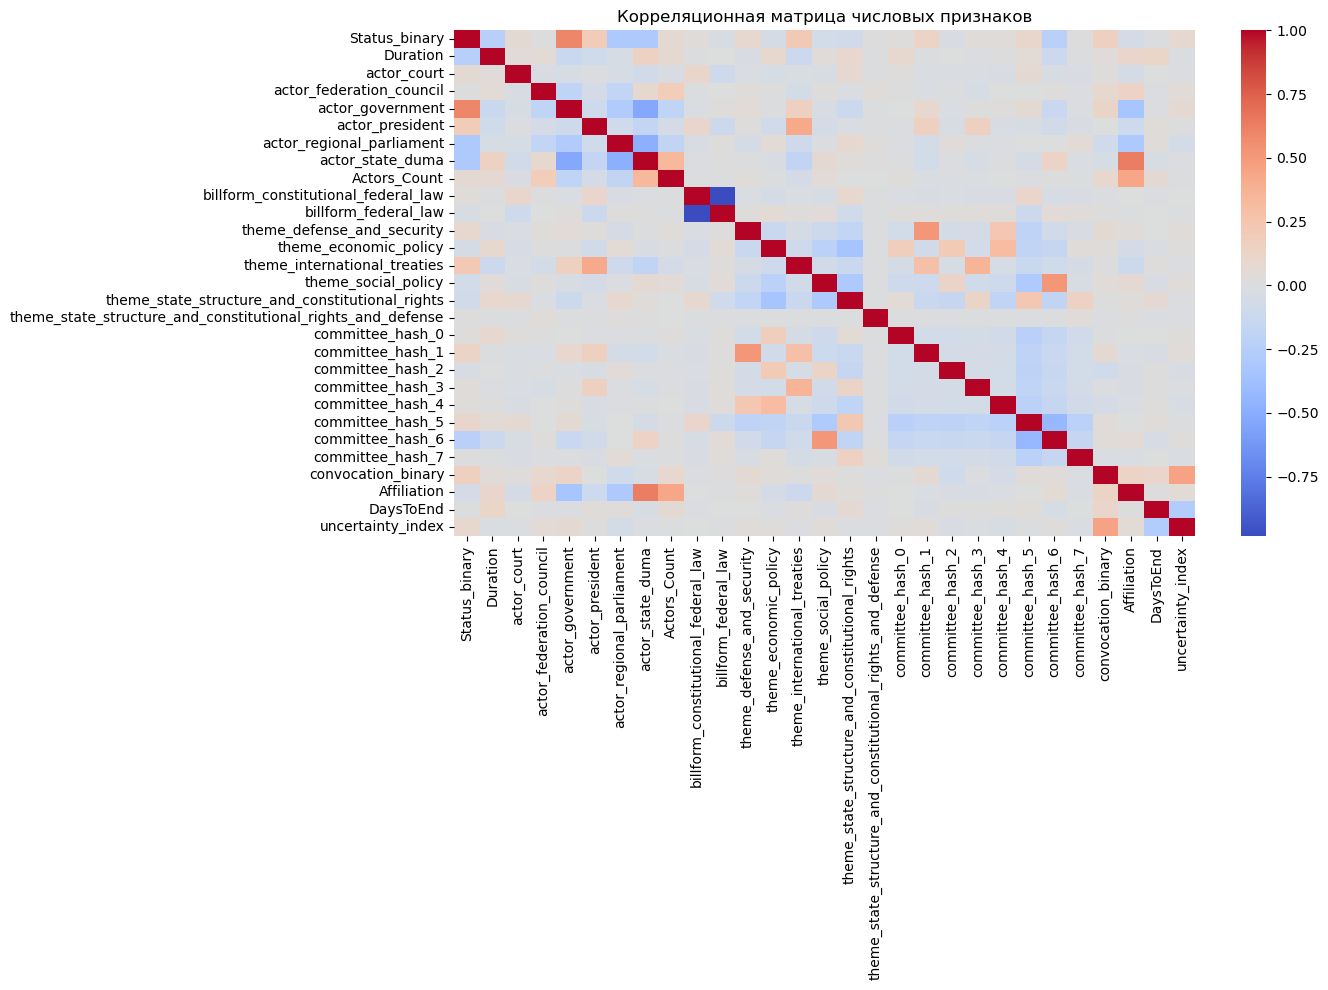

In [75]:
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(numeric_only=True), cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

Рассчитаем медиану времени рассмотрения законопроекта.

In [430]:
kmf.fit(durations=data['Duration'], event_observed=data['Status_binary'])  
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
median_confidence_interval_.columns = ['lower_0.95', 'upper_0.95']
print(median_)
print(median_confidence_interval_)

713.0
     lower_0.95  upper_0.95
0.5       657.0       757.0


## Построение моделей

После описательного построим полупараметрическую модель пропорциональных рисков Кокса.

Вначале проверим данные на наличие мультиколлинеарности с помощью расчёта коэффициента VIF (Variance Inflation Factor).

In [170]:
feature_cols = [col for col in data.columns if col not in ['duration', 'event']]
X = data[feature_cols].dropna().astype(float)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))

                                feature         VIF
20                     committee_hash_5  995.883416
21                     committee_hash_6  590.496368
15                     committee_hash_0  196.672317
22                     committee_hash_7  188.997997
19                     committee_hash_4  184.488579
17                     committee_hash_2  166.361857
16                     committee_hash_1  153.115411
18                     committee_hash_3  140.557801
14                 billform_federal_law   28.549978
13  billform_constitutional_federal_law   28.480487
9                      actor_government    2.824642
5                         Status_binary    2.233591
1                  defense_and_security    1.834734
24                          Affiliation    1.801876
3                international_treaties    1.707171
4                         social_policy    1.684167
2                       economic_policy    1.578278
11            actor_regional_parliament    1.571720
10          

Хешированные признаки комитетов оказались сильно коррелированы между собой. Чтобы устранить мультиколлинеарность, снизим размерность с помощью метода главных компонент (PCA).

In [171]:
committee_hash_cols = [col for col in data.columns if col.startswith('committee_hash_')]
pca = PCA(n_components=2)
committee_pca = pca.fit_transform(data[committee_hash_cols])

data['committee_pca_0'] = committee_pca[:, 0]
data['committee_pca_1'] = committee_pca[:, 1]
data.drop(columns=committee_hash_cols, inplace=True)

После обработки пересчитаем VIF, чтобы убедиться в отсутствии мультиколлинеарности перед построением модели.

In [172]:
feature_cols = [col for col in data.columns if col not in ['duration', 'event']]
X = data[feature_cols].dropna().astype(float)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values('VIF', ascending=False))

                                feature        VIF
14                 billform_federal_law  14.989584
18                    uncertainty_index   6.037034
17                            DaysToEnd   4.836615
9                      actor_government   3.673445
5                         Status_binary   3.668906
15                   convocation_binary   2.628504
16                          Affiliation   2.476434
6                              Duration   2.176580
11            actor_regional_parliament   1.982292
4                         social_policy   1.870911
2                       economic_policy   1.717754
10                      actor_president   1.593776
19                      committee_pca_0   1.571515
0                 budget_and_tax_policy   1.509144
12                         Actors_Count   1.480756
3                international_treaties   1.452933
20                      committee_pca_1   1.437601
8              actor_federation_council   1.329078
1                  defense_and_

Теперь построим саму модель.

In [173]:
cph = CoxPHFitter()
cph.fit(data, duration_col='Duration', event_col='Status_binary')

print(cph.print_summary())

<lifelines.CoxPHFitter: fitted with 12867 total observations, 7810 right-censored observations>
             duration col = 'Duration'
                event col = 'Status_binary'
      baseline estimation = breslow
   number of observations = 12867
number of events observed = 5057
   partial log-likelihood = -41404.84
         time fit was run = 2025-05-23 13:44:52 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
budget_and_tax_policy                0.44      1.55      0.04            0.35            0.53                1.42                1.70
defense_and_security                 0.23      1.26      0.06            0.11            0.35                1.12                1.42
economic_policy                     -0.20      0.82      0.04           -0.29           -0.11                0.75                0.89
international_treaties               1.09      2.97      0.07            0.96            1.22                2.61                3.39
social_policy                        0.09      1.10      0.06           -0.03            0.21                0.97                1.23
actor_court                          1.90      6.67      0.14            1.63            2.17                5.08                8.76
actor_federation_council             0.78      2.18      0.05            0.67            0.88                1.96                2.42
actor_government                     2.56     12.89      0.06            2.44            2.67               11.48               14.47
actor_president                      3.12     22.73      0.09            2.96            3.29               19.23               26.88
actor_regional_parliament            0.35      1.41      0.08            0.19            0.50                1.21                1.65
Actors_Count                         0.01      1.01      0.00            0.01            0.01                1.01                1.01
billform_constitutional_federal_law -0.41      0.66      0.59           -1.57            0.74                0.21                2.10
billform_federal_law                -0.73      0.48      0.58           -1.86            0.41                0.15                1.50
convocation_binary                   0.12      1.13      0.03            0.06            0.19                1.06                1.20
Affiliation                          0.89      2.43      0.06            0.77            1.00                2.16                2.73
DaysToEnd                           -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
uncertainty_index                    0.00      1.00      0.00           -0.00            0.00                1.00                1.00
committee_pca_0                     -0.10      0.90      0.04           -0.18           -0.02                0.83                0.98
committee_pca_1                     -0.25      0.78      0.05           -0.35           -0.15                0.70                0.86

                                     cmp to     z      p  -log2(p)
covariate                                                         
budget_and_tax_policy                  0.00  9.88 <0.005     74.04
defense_and_security                   0.00  3.90 <0.005     13.33
economic_policy                        0.00 -4.51 <0.005     17.22
international_treaties                 0.00 16.44 <0.005    199.28
social_policy                          0.00  1.54   0.12      3.01
actor_court                            0.00 13.65 <0.005    138.51
actor_federation_council               0.00 14.56 <0.005    157.16
actor_government                       0.00 43.32 <0.005       inf
actor_president                        0.00 36.57 <0.005    970.12
actor_regional_parliament              0.00  4.42 <0.005     16.60
Acto

None


In [175]:
results_df = cph.summary
results_df_rounded = results_df.round(2)
columns_to_keep = [
    'coef', 'exp(coef)', 'se(coef)', 'coef lower 95%', 'coef upper 95%', 'z', 'p'
]
results_df_rounded[columns_to_keep].to_csv("cox_model_clean_rounded.csv")

И визуализируем коэффициенты.

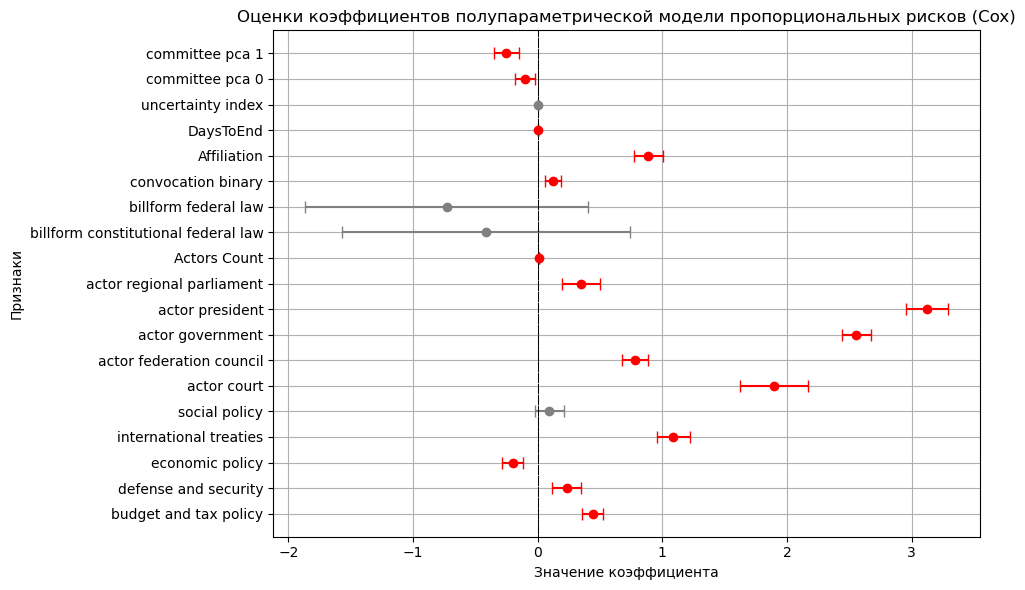

In [176]:
summary = cph.summary.copy()

summary = summary[~summary.index.str.startswith('baseline')]

significant = summary['p'] < 0.05

plt.figure(figsize=(10, 6))
for i, (coef, err, label, sig) in enumerate(zip(summary['coef'], summary['se(coef)'], summary.index, significant)):
    color = 'red' if sig else 'gray'
    plt.errorbar(
        x=coef,
        y=i,
        xerr=1.96 * err,
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4,
        label='_nolegend_'
    )
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)


plt.yticks(range(len(summary)), [label.replace('_', ' ') for label in summary.index])
plt.xlabel('Значение коэффициента')
plt.ylabel('Признаки')
plt.title('Оценки коэффициентов полупараметрической модели пропорциональных рисков (Cox)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [215]:
data_aft = data.copy()
data_aft['Duration'] = data_aft['Duration'].clip(lower=0.5)

Перейдём к построению параметрической модели выживания. Прежде чем выбрать конкретную модель, определим, какое распределение времени до события наилучшим образом соответствует нашим данным.

In [217]:
models = {
    "Weibull": WeibullFitter(),
    "Exponential": ExponentialFitter(),
    "LogNormal": LogNormalFitter(),
    "LogLogistic": LogLogisticFitter()
}

for name, model in models.items():
    model.fit(data_aft['Duration'], event_observed=data_aft['Status_binary'])
    print(f"{name}: AIC = {model.AIC_:.2f}")

Weibull: AIC = 79527.46
Exponential: AIC = 79839.00
LogNormal: AIC = 78528.79
LogLogistic: AIC = 78907.78


Наименьшее значение AIC наблюдается у логнормального распределения, что говорит о его лучшем соответствии данным по сравнению с другими вариантами. Используем его для оценки коэффициентов в модели ускоренного времени.

In [218]:
aft = LogNormalAFTFitter()
aft.fit(data_aft, duration_col='Duration', event_col='Status_binary')

aft.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 12865 total observations, 7808 right-censored observations>
             duration col = 'Duration'
                event col = 'Status_binary'
   number of observations = 12865
number of events observed = 5057
           log-likelihood = -36604.42
         time fit was run = 2025-05-24 09:03:02 UTC

---
                                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                                            
mu_    Actors_Count                        -0.01      0.99      0.00           -0.02           -0.01                0.98                0.99
       Affiliation                         -0.74      0.48      0.05           -0.84           -0.64                0.43                0.52
       DaysToEnd                            0.00      1.00      0.00            0.00            0.00                1.00                1.00
       actor_court                         -1.55      0.21      0.15           -1.85           -1.24                0.16                0.29
       actor_federation_council            -0.68      0.51      0.05           -0.78           -0.58                0.46                0.56
       actor_government                    -2.37      0.09      0.05           -2.47           -2.27                0.08                0.10
       actor_president                     -2.83      0.06      0.09           -3.01           -2.66                0.05                0.07
       actor_regional_parliament           -0.25      0.78      0.06           -0.37           -0.13                0.69                0.87
       billform_constitutional_federal_law -0.49      0.61      0.66           -1.78            0.80                0.17                2.23
       billform_federal_law                 0.17      1.18      0.65           -1.10            1.43                0.33                4.19
       budget_and_tax_policy               -0.46      0.63      0.05           -0.56           -0.37                0.57                0.69
       committee_pca_0                      0.14      1.15      0.04            0.06            0.22                1.06                1.25
       committee_pca_1                      0.26      1.30      0.05            0.16            0.37                1.17                1.44
       convocation_binary                   0.00      1.00      0.04           -0.07            0.07                0.94                1.07
       defense_and_security                -0.19      0.83      0.07           -0.31           -0.06                0.73                0.94
       economic_policy                      0.24      1.27      0.05            0.15            0.33                1.16                1.39
       international_treaties              -0.87      0.42      0.08           -1.02           -0.71                0.36                0.49
       social_policy                       -0.01      0.99      0.06           -0.13            0.11                0.88                1.12
       uncertainty_index                   -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
       Intercept                            7.51   1832.45      0.65            6.24            8.79              513.01             6545.46
sigma_ Intercept                            0.25      1.29      0.01            0.23            0.27                1.26                1.31

                                            cmp to      z      p  -log2(p)
param  covariate                                                          
mu_    Actors_Count                           0.00 -10.74 <0.005     87.00
       Affiliation                            0.00 -14.85 <0.005    163.33
       DaysToEnd                              0.00   5.71 <0.005     26.44
       actor_court               

In [220]:
results_aft_df = aft.summary
results_aft_df_rounded = results_aft_df.round(2)
columns_to_keep = [
    'coef', 'exp(coef)', 'se(coef)', 'coef lower 95%', 'coef upper 95%', 'z', 'p'
]
results_aft_df_rounded[columns_to_keep].to_csv("param_model_clean_rounded.csv")

И визуализируем результаты.

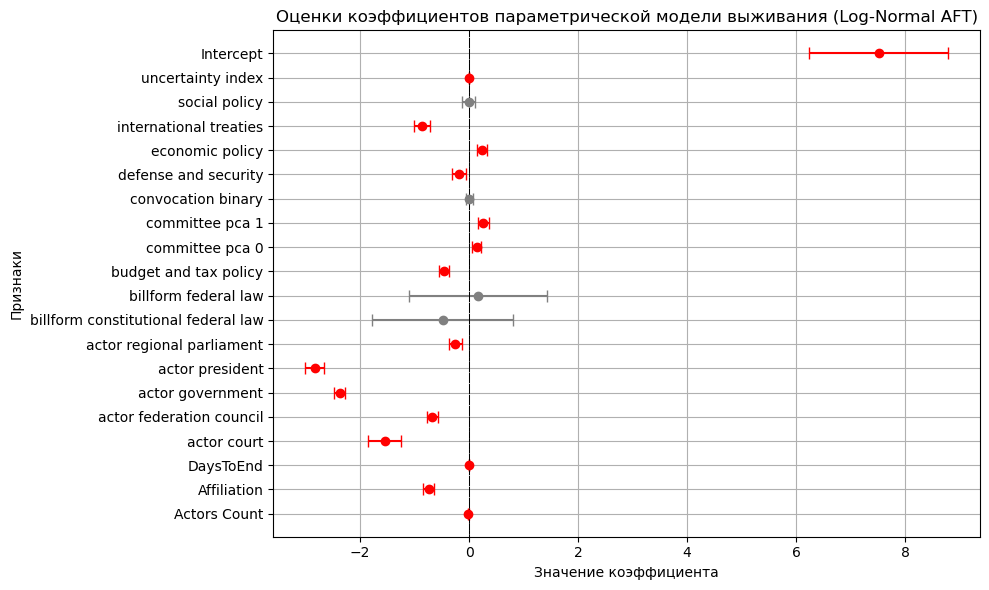

In [221]:
summary = aft.summary
summary = summary[summary.index.get_level_values(0) == 'mu_']

significant = summary['p'] < 0.05

plt.figure(figsize=(10, 6))
for i, (coef, err, label, sig) in enumerate(zip(summary['coef'], summary['se(coef)'], summary.index.get_level_values(1), significant)):
    color = 'red' if sig else 'gray'
    plt.errorbar(
        x=coef,
        y=i,
        xerr=1.96 * err,
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4,
        label='_nolegend_'
    )
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

plt.yticks(range(len(summary)), [label.replace('_', ' ') for label in summary.index.get_level_values(1)])
plt.xlabel('Значение коэффициента')
plt.ylabel('Признаки')
plt.title('Оценки коэффициентов параметрической модели выживания (Log-Normal AFT)')
plt.grid(True)
plt.tight_layout()
plt.show()